In [1]:
using BSON
using DrWatson
using LinearAlgebra
using SparseArrays
using Pkg
Pkg.activate("/home/dabajabaza/jianguoyun/Nutstore/LatticeLab")
using LatticeLab
Pkg.activate("/home/dabajabaza/jianguoyun/Nutstore/BandStructures")
using BandStructures
using PyCall
phonopy = pyimport("phonopy")
sk = pyimport("seekpath")

PyObject <module 'phonopy' from '/home/dabajabaza/anaconda3/lib/python3.8/site-packages/phonopy/__init__.py'>

In [3]:
pwd()

"/home/dabajabaza/jianguoyun/Nutstore/LatticeLab/examples"

In [6]:
function lattice_dynmat_from_phonopy(
    ph::PyCall.PyObject,
    POSCAR::String, 
    FORSE_SETS::String, 
    CONF::String;
    max_distance=30.0,
    maxlen=20,
    margin=6, 
    bounding_box=([-0.001,-0.0004,-0.0006],[1 0 0; 0 1 0; 0 0 1],[1,1,1],[true,true,true]),
    rounding_digits=5,
    PHONOPY_EPS=1e-6,
    PHONOPY_PREC_CTRL=8
    )

    println("\n-------------------------------\nlattice_dynmat_from_phonopy():")
    confs = [   "max_distance=$max_distance",
                "maxlen=$maxlen",
                "margin=$margin",
                "bounding_box=$bounding_box",
                "rounding_digits=$rounding_digits",
                "PHONOPY_EPS=$PHONOPY_EPS",
                "PHONOPY_PREC_CTRL=$PHONOPY_PREC_CTRL",  ]
    @info "Configurations:\n" * join(confs, "\n\t")
    println("")

    @info "LatticeLab.PhonopyCopy_from_vasp"
    @time PH = LatticeLab.PhonopyCopy_from_vasp(ph, POSCAR, FORSE_SETS, CONF)

    @info "LatticeLab.all_links_between_sublattices"
    @time ALL_LN = LatticeLab.all_links_between_sublattices(
                                    PH.UC; 
                                    maxlen=maxlen,
                                    max_distance=max_distance,
                                    large_enough_margin=margin, 
                                    bounding_box=bounding_box,
                                    rounding_digits=rounding_digits )

    @info "LatticeLab.extract_force_constants"
    @time SP, NB = LatticeLab.extract_force_constants(
                                    PH, ALL_LN;
                                    SVEC_PREC_CTRL=PHONOPY_PREC_CTRL, 
                                    FC_PREC_CTRL=PHONOPY_PREC_CTRL, 
                                    SVEC_NORM_EPS=PHONOPY_EPS,
                                    FC_EPS=PHONOPY_EPS )

    @info "LatticeLab.build_lattice"
    @time LATT = LatticeLab.build_lattice(NB, bounding_box)

    @info "LatticeLab.kspace_dynamical_matrix"
    @time DM = LatticeLab.kspace_dynamical_matrix(SP, PH.MASS, LATT)

    return PH, DM
end

lattice_dynmat_from_phonopy (generic function with 1 method)

In [7]:
function process_phonopy_database_element(
    ph::PyCall.PyObject, 
    MP::String, 
    FD::String; 
    rounding_digits=4, 
    margin=6,
    max_distance=20.0,
    maxlen=20,
    )

    POSCAR = "$FD/$MP/POSCAR-unitcell"
    FORcE = "$FD/$MP/" * (isfile("$FD/$MP/FORCE_SETS") ? "FORCE_SETS" : "FORCE_CONSTANTS")
    @assert isfile(FORcE)
    CONF = "$FD/$MP/phonopy.conf"
    PH, DM, err = (nothing, nothing, nothing)
    try
        PH, DM = lattice_dynmat_from_phonopy(
                        ph, POSCAR, FORcE, CONF,
                        rounding_digits=rounding_digits, 
                        max_distance=max_distance,
                        maxlen=maxlen,
                        margin=margin
        )
    catch _e_
        err = string(typeof(_e_))
        rethrow(_e_)
    end
    BSON.bson(  "$FD/$MP/LatticeLab_parse_result_$(MP).bson", 
                RESULTS=(PH=PH,
                         rounding_digits=rounding_digits, margin=margin,
                         err=err)   )
    return DM, err
end

process_phonopy_database_element (generic function with 1 method)

In [26]:
function plot_band_mp(
    OPS,
    figure_file_name,
    DM, 
    HighSymmRel; 
    Δk=0.01,
    COLOR=["red","blue","green","orange"], 
    SIZE = 40.0,
    settings=Dict(  :colors=>["black",],
                    :lw=>0.4,
                    :range=>nothing,
                    :fontsize=>12,
                    :markerstrokealpha=>0.7,
                    :markerstrokewidth=>0.2,
                    :markersizetrimratio=>0.01,
                    :aspect_ratio=>3,
                    :figure_size => (10,4),   )
    )
    b   = LatticeLab.reciprocal_basis(DM.LATT.UC)
    HighSymmAbs = [[name=>b*qrel for (name,qrel) ∈ HS] for HS ∈ HighSymmRel]
    BS  = [ LatticeLab.band_structure_with_eigenvectors(
                HSA, DM; 
                Δk=Δk, test_eigen=false, eps=1e-8)
            for HSA ∈ HighSymmAbs]
    BS1 = [ compute_band_markers(
                b, OPS
            ) |> BandStructures.LatticeLab_bands_BandStructure
            for b in BS ];
    plot_bands(
            figure_file_name, BS1; 
            dpi=800, COLOR=COLOR, SIZE=SIZE, settings=settings )
    return BS1
end

plot_band_mp (generic function with 1 method)

In [34]:
OPS_EL(UC,EL) = [ (k,v)->abs(v'*AtomProjector(EL,UC)*v) ]

OPS_EL (generic function with 1 method)

In [36]:
@inline l2b(UC) = BandStructures.UnitCell(3,UC.nsubl,UC.a,UC.δ,UC.m,UC.ξ)

l2b (generic function with 1 method)

# Material 1

In [47]:
DM, err = process_phonopy_database_element( phonopy, 
                                            "mp-830-20180417", # CHEM = "NaSbCu"
                                            "./", 
                                            rounding_digits=5,
                                            max_distance=50.0,
                                            maxlen=40 )
HighSymmRel = kpath(call_get_path(sk, l2b(DM.LATT.UC); with_time_reversal=false)) ;


-------------------------------
lattice_dynmat_from_phonopy():



┌ Info: Configurations:
│ max_distance=50.0
│ 	maxlen=40
│ 	margin=6
│ 	bounding_box=([-0.001, -0.0004, -0.0006], [1 0 0; 0 1 0; 0 0 1], [1, 1, 1], Bool[1, 1, 1])
│ 	rounding_digits=5
│ 	PHONOPY_EPS=1.0e-6
│ 	PHONOPY_PREC_CTRL=8
└ @ Main In[6]:23
┌ Info: LatticeLab.PhonopyCopy_from_vasp
└ @ Main In[6]:26


  0.114308 seconds (2.21 k allocations: 935.656 KiB)
  0.007125 seconds (88.38 k allocations: 7.134 MiB)
  0.054988 seconds (893.90 k allocations: 71.644 MiB, 46.80% gc time)


┌ Info: LatticeLab.all_links_between_sublattices
└ @ Main In[6]:29
┌ Info: LatticeLab.extract_force_constants
└ @ Main In[6]:38
┌ Info: LatticeLab.build_lattice
└ @ Main In[6]:46
┌ Info: build_lattice() : 
│ 		 margin = 3
└ @ LatticeLab /home/dabajabaza/jianguoyun/Nutstore/LatticeLab/src/lattice/build_lattice.jl:256
┌ Info: generate_R0_compute_EqV() : 
│ 		 bbox = ([-0.001, -0.0004, -0.0006], [1 0 0; 0 1 0; 0 0 1], [1, 1, 1], Bool[1, 1, 1])
│ 		 N_min, N_max = ([-3, -4, -4], [5, 5, 5])
└ @ LatticeLab /home/dabajabaza/jianguoyun/Nutstore/LatticeLab/src/lattice/build_lattice.jl:39
┌ Info: generate_R0_compute_EqV() : compute EqV ...
└ @ LatticeLab /home/dabajabaza/jianguoyun/Nutstore/LatticeLab/src/lattice/build_lattice.jl:53


  2.173985 seconds (17.39 M allocations: 1.268 GiB, 6.82% gc time)
  0.000968 seconds (10.55 k allocations: 518.531 KiB)
  2.177739 seconds (17.42 M allocations: 1.271 GiB, 6.81% gc time)
  0.012830 seconds (7.90 k allocations: 1.112 MiB, 90.33% gc time)


┌ Info: generate_f() : main loop ...
└ @ LatticeLab /home/dabajabaza/jianguoyun/Nutstore/LatticeLab/src/lattice/build_lattice.jl:180
┌ Info: LatticeLab.kspace_dynamical_matrix
└ @ Main In[6]:49


	71.058% of 4236 markers to be scattered ...


┌ Info: plot_bands()  : initializing ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:157
┌ Info: plot_bands!() : plotting frames ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:70
┌ Info: plot_bands!() : markers 
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:91
┌ Info: plot_bands!() : computing markers ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:92
┌ Info: plot_bands!() : ploting markers ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:98
┌ Info: plot_bands!() : plotting lines ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:108
┌ Info: plot_bands!() : plotting auxilary levels ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:122
┌ Info: plot_b

	78.14% of 4236 markers to be scattered ...


┌ Info: plot_bands()  : initializing ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:157
┌ Info: plot_bands!() : plotting frames ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:70
┌ Info: plot_bands!() : markers 
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:91
┌ Info: plot_bands!() : computing markers ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:92
┌ Info: plot_bands!() : ploting markers ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:98
┌ Info: plot_bands!() : plotting lines ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:108
┌ Info: plot_bands!() : plotting auxilary levels ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:122
┌ Info: plot_b

	96.601% of 4236 markers to be scattered ...


┌ Info: plot_bands()  : initializing ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:157
┌ Info: plot_bands!() : plotting frames ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:70
┌ Info: plot_bands!() : markers 
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:91
┌ Info: plot_bands!() : computing markers ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:92
┌ Info: plot_bands!() : ploting markers ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:98
┌ Info: plot_bands!() : plotting lines ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:108
┌ Info: plot_bands!() : plotting auxilary levels ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:122
┌ Info: plot_b

	94.806% of 4236 markers to be scattered ...


┌ Info: plot_bands()  : initializing ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:157
┌ Info: plot_bands!() : plotting frames ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:70
┌ Info: plot_bands!() : markers 
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:91
┌ Info: plot_bands!() : computing markers ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:92
┌ Info: plot_bands!() : ploting markers ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:98
┌ Info: plot_bands!() : plotting lines ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:108


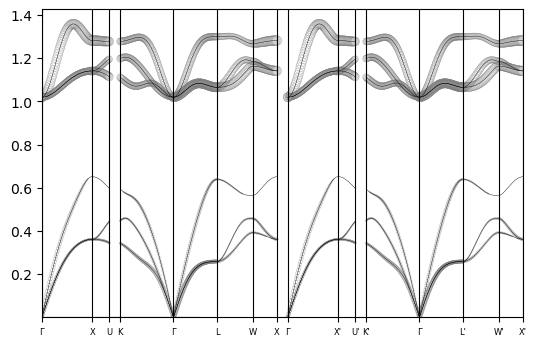

┌ Info: plot_bands!() : plotting auxilary levels ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:122
┌ Info: plot_bands!() : saving ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:138


In [48]:
ALONG  = [("Ga",LOPS_EL(DM.LATT.UC,:Ga),"red"),
          ("N", LOPS_EL(DM.LATT.UC,:N),"grey") ]

ATTRANS = [("Ga",TOPS_EL(DM.LATT.UC,:Ga),"red"),
           ("N", TOPS_EL(DM.LATT.UC,:N),"grey") ]

for (A,lt) in [(ALONG,"L"), (ATTRANS,"T")]
    for (atm, proj, col) in A
        plot_band_mp(
            proj,
            "GaN_$(lt)_$(atm).png",
            DM, 
            HighSymmRel; 
            Δk=0.01,
            COLOR=[col,], 
            SIZE = 50.0,
            settings=Dict(  :colors=>["black",],
                            :lw=>0.3,
                            :fontsize=>6,
                            :K_sep => 0.3,
                            :markerstrokealpha=>0.6,
                            :markerstrokewidth=>0.3,
                            :markersizetrimratio=>0.01,
                            :aspect_ratio=>6,
                            :figure_size => (8,4) ) )
    end
end

# Material 2

In [32]:
DM, err = process_phonopy_database_element( phonopy, 
                                            "mp-999901-20180417", # CHEM = "NaSbCu"
                                            "./", 
                                            rounding_digits=5,
                                            max_distance=50.0,
                                            maxlen=40 )
HighSymmRel = kpath(call_get_path(sk, l2b(DM.LATT.UC); with_time_reversal=false)) ;


-------------------------------
lattice_dynmat_from_phonopy():



┌ Info: Configurations:
│ max_distance=50.0
│ 	maxlen=40
│ 	margin=6
│ 	bounding_box=([-0.001, -0.0004, -0.0006], [1 0 0; 0 1 0; 0 0 1], [1, 1, 1], Bool[1, 1, 1])
│ 	rounding_digits=5
│ 	PHONOPY_EPS=1.0e-6
│ 	PHONOPY_PREC_CTRL=8
└ @ Main In[6]:23
┌ Info: LatticeLab.PhonopyCopy_from_vasp
└ @ Main In[6]:26


  0.384929 seconds (246.80 k allocations: 24.500 MiB, 29.36% compilation time)


┌ Info: LatticeLab.all_links_between_sublattices
└ @ Main In[6]:29


  2.469283 seconds (342.77 k allocations: 41.939 MiB, 0.46% gc time, 98.14% compilation time)
  0.084036 seconds (1.22 M allocations: 67.832 MiB, 15.47% gc time)


┌ Info: LatticeLab.extract_force_constants
└ @ Main In[6]:38
┌ Info: LatticeLab.build_lattice
└ @ Main In[6]:46
┌ Info: build_lattice() : 
│ 		 margin = 2
└ @ LatticeLab /home/dabajabaza/jianguoyun/Nutstore/LatticeLab/src/lattice/build_lattice.jl:256
┌ Info: generate_R0_compute_EqV() : 
│ 		 bbox = ([-0.001, -0.0004, -0.0006], [1 0 0; 0 1 0; 0 0 1], [1, 1, 1], Bool[1, 1, 1])
│ 		 N_min, N_max = ([-3, -3, -3], [4, 4, 4])
└ @ LatticeLab /home/dabajabaza/jianguoyun/Nutstore/LatticeLab/src/lattice/build_lattice.jl:39
┌ Info: generate_R0_compute_EqV() : compute EqV ...
└ @ LatticeLab /home/dabajabaza/jianguoyun/Nutstore/LatticeLab/src/lattice/build_lattice.jl:53


  2.421296 seconds (22.93 M allocations: 1.610 GiB, 9.02% gc time)
  0.029715 seconds (189.71 k allocations: 8.956 MiB, 56.49% gc time)
  2.483354 seconds (23.27 M allocations: 1.631 GiB, 9.47% gc time, 1.07% compilation time)
  0.008999 seconds (72.88 k allocations: 15.463 MiB)


┌ Info: generate_f() : main loop ...
└ @ LatticeLab /home/dabajabaza/jianguoyun/Nutstore/LatticeLab/src/lattice/build_lattice.jl:180
┌ Info: LatticeLab.kspace_dynamical_matrix
└ @ Main In[6]:49


	95.367% of 12864 markers to be scattered ...


┌ Info: plot_bands()  : initializing ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:157
┌ Info: plot_bands!() : plotting frames ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:70
┌ Info: plot_bands!() : markers 
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:91
┌ Info: plot_bands!() : computing markers ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:92
┌ Info: plot_bands!() : ploting markers ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:98
┌ Info: plot_bands!() : plotting lines ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:108
┌ Info: plot_bands!() : plotting auxilary levels ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:122
┌ Info: plot_b

	92.708% of 12864 markers to be scattered ...


┌ Info: plot_bands()  : initializing ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:157
┌ Info: plot_bands!() : plotting frames ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:70
┌ Info: plot_bands!() : markers 
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:91
┌ Info: plot_bands!() : computing markers ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:92
┌ Info: plot_bands!() : ploting markers ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:98
┌ Info: plot_bands!() : plotting lines ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:108
┌ Info: plot_bands!() : plotting auxilary levels ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:122
┌ Info: plot_b

	68.493% of 12864 markers to be scattered ...


┌ Info: plot_bands()  : initializing ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:157
┌ Info: plot_bands!() : plotting frames ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:70
┌ Info: plot_bands!() : markers 
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:91
┌ Info: plot_bands!() : computing markers ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:92
┌ Info: plot_bands!() : ploting markers ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:98
┌ Info: plot_bands!() : plotting lines ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:108


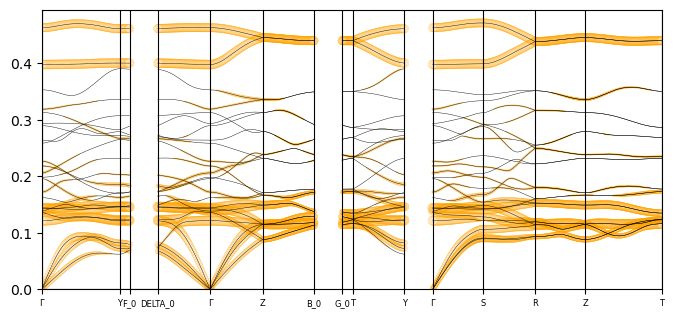

┌ Info: plot_bands!() : plotting auxilary levels ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:122
┌ Info: plot_bands!() : saving ...
└ @ BandStructures /home/dabajabaza/jianguoyun/Nutstore/BandStructures/src/plot/plot_bands.jl:138


In [40]:
A = [("Na",OPS_EL(DM.LATT.UC,:Na),"red"),
     ("Sb",OPS_EL(DM.LATT.UC,:Sb),"grey"),
     ("Cu",OPS_EL(DM.LATT.UC,:Cu),"orange")]

for (atm, proj, col) in A
    plot_band_mp(
        proj,
        "NaSbCu_$(atm).pdf",
        DM, 
        HighSymmRel; 
        Δk=0.01,
        COLOR=[col,], 
        SIZE = 50.0,
        settings=Dict(  :colors=>["black",],
                        :lw=>0.3,
                        :fontsize=>6,
                        :K_sep => 0.3,
                        :markerstrokealpha=>0.6,
                        :markerstrokewidth=>0.3,
                        :markersizetrimratio=>0.01,
                        :aspect_ratio=>6,
                        :figure_size => (8,4) ) )
end